#Recurrent Neural Networks using High-Level APIs (Chapter 9)
Implement the autoregressive model of Section 9.1 of the textbook using an RNN and
high-level APIs.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')

import d2l
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

Mounted at /content/gdrive


### Without APIs

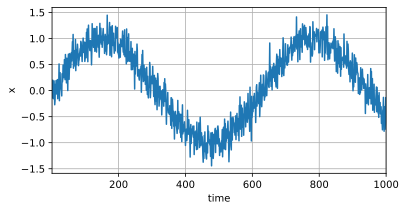

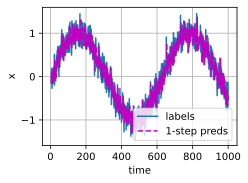

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


class Data(d2l.DataModule):
    def __init__(self, batch_size=16, T=1000, num_train=600, tau=4):
        self.save_hyperparameters()
        self.time = torch.arange(1, T + 1, dtype=torch.float32)
        self.x = torch.sin(0.01 * self.time) + torch.randn(T) * 0.2

    def get_dataloader(self, train):
      features = [self.x[i : self.T-self.tau+i] for i in range(self.tau)]
      self.features = torch.stack(features, 1)
      self.labels = self.x[self.tau:].reshape((-1, 1))
      i = slice(0, self.num_train) if train else slice(self.num_train, None)
      return self.get_tensorloader([self.features, self.labels], train, i)

data = Data()
d2l.plot(data.time, data.x, 'time', 'x', xlim=[1, 1000], figsize=(6, 3))


model = d2l.LinearRegression(lr=0.01)
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)

onestep_preds = model(data.features).detach().numpy()
d2l.plot(data.time[data.tau:], [data.labels, onestep_preds], 'time', 'x',
         legend=['labels', '1-step preds'], figsize=(6, 3))

### With APIs and RNN

In [ ]:
# # Utilizing 9.1 Data
# class Data(d2l.DataModule):
#     def __init__(self, batch_size=320, T=1000, num_train=600, tau=4, randn=0.2): # tau =  Markov condition, tau past observations
#         self.save_hyperparameters()
#         self.time = torch.range(1, T, dtype=torch.float32)
#         self.x = torch.sin(0.01*self.time) + torch.randn(T)*randn

#     def get_dataloader(self, train):
#         features = [self.x[i:self.T-self.tau+i] for i in range(self.tau)]
#         labels = [self.x[i:self.T-self.tau+i] for i in range(1,self.tau+1)]
#         self.features = torch.stack(features, 1).unsqueeze(dim=-1)#.swapaxes(0, 1)
#         self.labels = torch.stack(labels, 1).unsqueeze(dim=-1)#.swapaxes(0, 1)
#         i = slice(0, self.num_train) if train else slice(self.num_train, None)
#         return self.get_tensorloader([self.features, self.labels], train, i)

# class RNNAutoRegression(d2l.LinearRegression):
#     def init_params(self):
#         self.linear = nn.LazyLinear(1)

#     def output_layer(self, hiddens):
#         return self.linear(hiddens).swapaxes(0, 1)

#     def __init__(self, rnn,lr=0.01, tau=4, plot_flag=True, emb_len=8):
#         super().__init__(lr=lr)
#         self.save_hyperparameters()
#         self.init_params()

#     def forward(self, X, state=None):
#         rnn_outputs, _ = self.rnn(X.swapaxes(0, 1), state)
#         outputs = [self.linear(H) for H in rnn_outputs]
#         return torch.stack(outputs, 1)


# data = Data()
# rnn = d2l.RNN(num_inputs=1, num_hiddens=8)
# model = d2l.RNNLM(rnn,vocab_size=len(data),lr=1)
# trainer = d2l.Trainer(max_epochs=10)
# trainer.fit(model, data)

<ipython-input-14-5cb3e7ae4f1c>:5: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  self.time = torch.range(1, T, dtype=torch.float32)


TypeError: object of type 'Data' has no len()

#### 10 Epochs

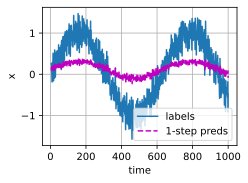

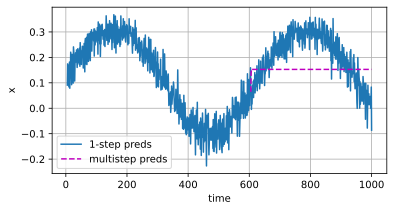

In [ ]:
# Utilizing 9.1 Data
class Data(d2l.DataModule):
    def __init__(self, batch_size=320, T=1000, num_train=600, tau=4, randn=0.2): # tau =  Markov condition, tau past observations
        self.save_hyperparameters()
        self.time = torch.range(1, T, dtype=torch.float32)
        self.x = torch.sin(0.01*self.time) + torch.randn(T)*randn

    def get_dataloader(self, train):
        features = [self.x[i:self.T-self.tau+i] for i in range(self.tau)]
        labels = [self.x[i:self.T-self.tau+i] for i in range(1,self.tau+1)]
        self.features = torch.stack(features, 1).unsqueeze(dim=-1)#.swapaxes(0, 1)
        self.labels = torch.stack(labels, 1).unsqueeze(dim=-1)#.swapaxes(0, 1)
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.features, self.labels], train, i)

class RNNAutoRegression(d2l.LinearRegression):
    def init_params(self):
        self.linear = nn.LazyLinear(1)

    def output_layer(self, hiddens):
        return self.linear(hiddens).swapaxes(0, 1)

    def __init__(self, rnn,lr=0.01, tau=4, plot_flag=True, emb_len=8):
        super().__init__(lr=lr)
        self.save_hyperparameters()
        self.init_params()

    def forward(self, X, state=None):
        rnn_outputs, _ = self.rnn(X.swapaxes(0, 1), state)
        outputs = [self.linear(H) for H in rnn_outputs]
        return torch.stack(outputs, 1)


data = Data()
rnn = d2l.RNN(num_inputs=1, num_hiddens=8)
model = RNNAutoRegression(rnn=rnn, lr=0.01)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)


# PLOT ####################
# One step predictions
onestep_preds = model(data.features).detach().numpy()
d2l.plot(data.time[data.tau:], [data.x[data.tau:], onestep_preds[:,-1].reshape(-1)], 'time', 'x',
         legend=['labels', '1-step preds'], figsize=(6, 3))

# Multistep predictions
plt.figure(figsize=(6, 3)) # need new figure to have both show
multistep_preds = torch.zeros(data.T)
multistep_preds[:] = data.x
for i in range(data.num_train + data.tau, data.T):
    temp = model(
        multistep_preds[i - data.tau:i].reshape((1,data.tau,1)))
    # print(temp.shape,temp[:,-1].item())
    multistep_preds[i] = temp[:,-1].item()
multistep_preds = multistep_preds.detach().numpy()
d2l.plot([data.time[data.tau:], data.time[data.num_train+data.tau:]],
         [onestep_preds[:,-1].reshape(-1), multistep_preds[data.num_train+data.tau:]], 'time',
         'x', legend=['1-step preds', 'multistep preds'], figsize=(6, 3))

#### Results for 100 Epochs

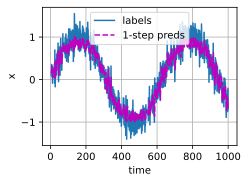

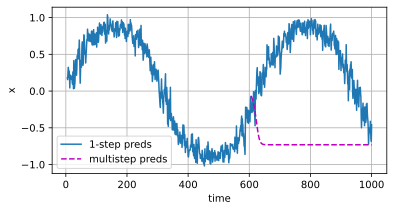

In [ ]:
# Utilizing 9.1 Data
class Data(d2l.DataModule):
    def __init__(self, batch_size=320, T=1000, num_train=600, tau=4, randn=0.2): # tau =  Markov condition, tau past observations
        self.save_hyperparameters()
        self.time = torch.range(1, T, dtype=torch.float32)
        self.x = torch.sin(0.01*self.time) + torch.randn(T)*randn

    def get_dataloader(self, train):
        features = [self.x[i:self.T-self.tau+i] for i in range(self.tau)]
        labels = [self.x[i:self.T-self.tau+i] for i in range(1,self.tau+1)]
        self.features = torch.stack(features, 1).unsqueeze(dim=-1)#.swapaxes(0, 1)
        self.labels = torch.stack(labels, 1).unsqueeze(dim=-1)#.swapaxes(0, 1)
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.features, self.labels], train, i)

class RNNAutoRegression(d2l.LinearRegression):
    def init_params(self):
        self.linear = nn.LazyLinear(1)

    def output_layer(self, hiddens):
        return self.linear(hiddens).swapaxes(0, 1)

    def __init__(self, rnn,lr=0.01, tau=4, plot_flag=True, emb_len=8):
        super().__init__(lr=lr)
        self.save_hyperparameters()
        self.init_params()

    def forward(self, X, state=None):
        rnn_outputs, _ = self.rnn(X.swapaxes(0, 1), state)
        outputs = [self.linear(H) for H in rnn_outputs]
        return torch.stack(outputs, 1)


data = Data()
rnn = d2l.RNN(num_inputs=1, num_hiddens=8)
model = RNNAutoRegression(rnn=rnn, lr=0.01)
trainer = d2l.Trainer(max_epochs=100)
trainer.fit(model, data)


# PLOT ####################
# One step predictions
onestep_preds = model(data.features).detach().numpy()
d2l.plot(data.time[data.tau:], [data.x[data.tau:], onestep_preds[:,-1].reshape(-1)], 'time', 'x',
         legend=['labels', '1-step preds'], figsize=(6, 3))

# Multistep predictions
plt.figure(figsize=(6, 3)) # need new figure to have both show
multistep_preds = torch.zeros(data.T)
multistep_preds[:] = data.x
for i in range(data.num_train + data.tau, data.T):
    temp = model(
        multistep_preds[i - data.tau:i].reshape((1,data.tau,1)))
    # print(temp.shape,temp[:,-1].item())
    multistep_preds[i] = temp[:,-1].item()
multistep_preds = multistep_preds.detach().numpy()
d2l.plot([data.time[data.tau:], data.time[data.num_train+data.tau:]],
         [onestep_preds[:,-1].reshape(-1), multistep_preds[data.num_train+data.tau:]], 'time',
         'x', legend=['1-step preds', 'multistep preds'], figsize=(6, 3))

#